In [2]:
import pandas as pd

In [3]:
df= pd.read_csv("C:\\Users\\acer\\Desktop\\ML projects\\text similarity\\complaints.csv")

In [4]:
df = df[['Consumer complaint  narrative','Product']]
df = df[pd.notnull(df['Consumer complaint narrative'])] # 
df.rename(columns = {'Consumer complaint narrative':'narrative'}, inplace = True)
 

In [5]:
df_subset = df.head(50000)

In [6]:
df_subset.index = range(50000)

In [12]:
df_subset.to_csv("C:\\Users\\acer\\Desktop\\ML projects\\text similarity\\df_subset.csv")

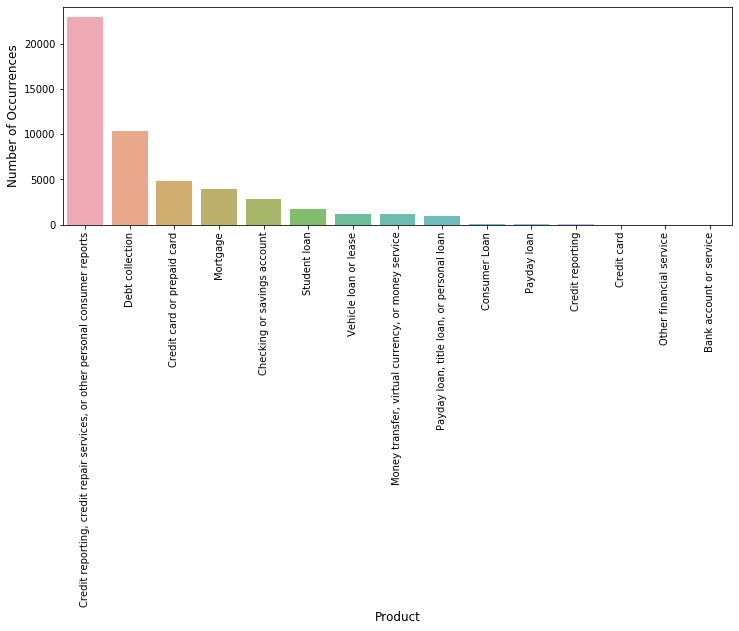

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
cnt_pro = df_subset['Product'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
from sklearn.model_selection import train_test_split
#selecting only thosd values which have more than 1 product value
df_subset = df_subset[df_subset['Product'].map(df_subset['Product'].value_counts()) > 1] 
train,test = train_test_split(df_subset, test_size=0.1, stratify = df_subset['Product'])
train.index = range(len(train))

In [47]:
text_corpus = train['narrative'].to_list()

In [48]:
texts = [[word for word in document.lower().split()]
         for document in text_corpus]


In [152]:
import nltk
#nltk.download()
list_id = list(train.index)
list_def = list(texts)

In [154]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
tagged_data = [TaggedDocument(words= term_def, tags=[list_id[i]]) for i, term_def in enumerate(list_def)]


In [156]:
model = gensim.models.doc2vec.Doc2Vec(dm=0, vector_size=100, min_count=5, epochs=10) #issue
model.build_vocab(tagged_data)

In [157]:
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [155]:
tagged_data

[TaggedDocument(words=['the', 'caller', 'said', 'we', 'owe', 'on', 'a', 'account.', 'we', "don't", 'have', 'a', 'account.', 'i', 'just', 'received', 'a', 'collection', 'letter', 'stating', 'they', 'will', 'accept', 'a', 'lower', 'amount', 'than', 'the', 'debt', 'listed.', 'the', 'collection', 'company', 'this', 'letter', 'is', 'from', 'is', 'american', 'coradius', 'international', 'llc', 'when', 'talking', 'with', ',', 'they', 'stated', 'they', 'can', 'not', 'look', 'up', 'anyone', "'s", 'account', 'to', 'see', 'if', 'what', "i'm", 'saying', 'is', 'true.'], tags=[0]),
 TaggedDocument(words=['this', 'account', 'does', 'not', 'belong', 'to', 'me!', 'please', 'remove', 'it', 'and', 'review', 'all', 'attached', 'documentation!'], tags=[1]),
 TaggedDocument(words=['i', 'tried', 'to', 'send', 'almost', '{$2000.00}', 'at', 'and', 'the', 'transaction', 'was', 'cancelled', 'due', 'to', 'having', 'no', 'id.', 'i', 'was', 'charged', 'but', 'never', 'received', 'the', 'service.', 'i', 'was', 'supp

In [213]:
x=test['narrative'].values[1]
test_data = x.lower().split()
v1 = model.infer_vector('test_data'.lower().split())

In [216]:
#enlists similar vectors to the searched text
sims_new = model.docvecs.most_similar([v1], topn=len(model.docvecs))
sims_df =  pd.DataFrame(sims_new)
sims_df.columns =['Index','similarity']
sims_df

,Index,similarity
0,12378,0.240570
1,6567,0.237048
2,9057,0.224756
3,438,0.220936
4,10114,0.212780
...,...,...
44993,36126,-0.328248
44994,36223,-0.330707
44995,23552,-0.336044
44996,30776,-0.361852


In [220]:
merged_inner = pd.merge(left=sims_df, right=train, left_on='Index', right_on=train.index)
merged_inner

,Index,similarity,narrative,Product
0,12378,0.240570,// the following is a timeline of what transpi...,"Money transfer, virtual currency, or money ser..."
1,6567,0.237048,"hi, i spend over dollars a month with americ...",Credit card or prepaid card
2,9057,0.224756,madeapaymentof{$110.00}toformycardaccounton//2...,"Credit reporting, credit repair services, or o..."
3,438,0.220936,bbva is holding my money hostage. i opened up ...,Checking or savings account
4,10114,0.212780,paypal illegally holding over {$8000.00} of re...,"Money transfer, virtual currency, or money ser..."
...,...,...,...,...
44993,36126,-0.328248,this complaint about unauthorized hard inquiry...,"Credit reporting, credit repair services, or o..."
44994,36223,-0.330707,the agency reported that check which i made p...,"Credit reporting, credit repair services, or o..."
44995,23552,-0.336044,on //2019 i checked my credit report with tran...,"Credit reporting, credit repair services, or o..."
44996,30776,-0.361852,this complaint is in regards to a hard credit ...,"Credit reporting, credit repair services, or o..."


In [225]:
#train[train.index == 448]["Product"]
test['Product'].values[1]

'Debt collection'

In [226]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [229]:
list_idtest = list(test.index)

text_corpustest = test['narrative'].to_list()
textstest = [[word for word in document.lower().split()]
         for document in text_corpustest]
list_deftest = list(textstest)

tagged_datatest = [TaggedDocument(words= term_def, tags=[list_idtest[i]]) for i, term_def in enumerate(list_deftest)]


In [230]:
y_train, X_train = vec_for_learning(model, tagged_data)
y_test, X_test = vec_for_learning(model, tagged_datatest)